In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import plotly.io as pio
from matminer.datasets import load_dataset
from tqdm import tqdm

from pymatviz import (
    annotate_bars,
    plot_structure_2d,
    ptable_heatmap_plotly,
    spacegroup_sunburst,
)
from pymatviz.utils import get_crystal_sys


pio.templates.default = "plotly_white"
# Comment out next line to get interactive plotly figures. Only used here since interactive
# figures don't show up at all in notebooks on GitHub. https://github.com/plotly/plotly.py/issues/931
pio.renderers.default = "svg"

plt.rc("font", size=14)
plt.rc("savefig", bbox="tight", dpi=200)
plt.rc("axes", titlesize=16, titleweight="bold")
plt.rcParams["figure.constrained_layout.use"] = True


In [5]:
df_perov = load_dataset("matbench_perovskites")

df_perov[["spglib_spg_symbol", "spglib_spg_num"]] = [
    struct.get_space_group_info() for struct in tqdm(df_perov.structure)
]
df_perov["volume"] = df_perov.structure.map(lambda struct: struct.volume)

df_perov["formula"] = df_perov.structure.map(lambda cryst: cryst.formula)

df_perov["spglib_crys_sys"] = df_perov.spglib_spg_num.map(get_crystal_sys)


100%|██████████| 18928/18928 [00:07<00:00, 2367.43it/s]


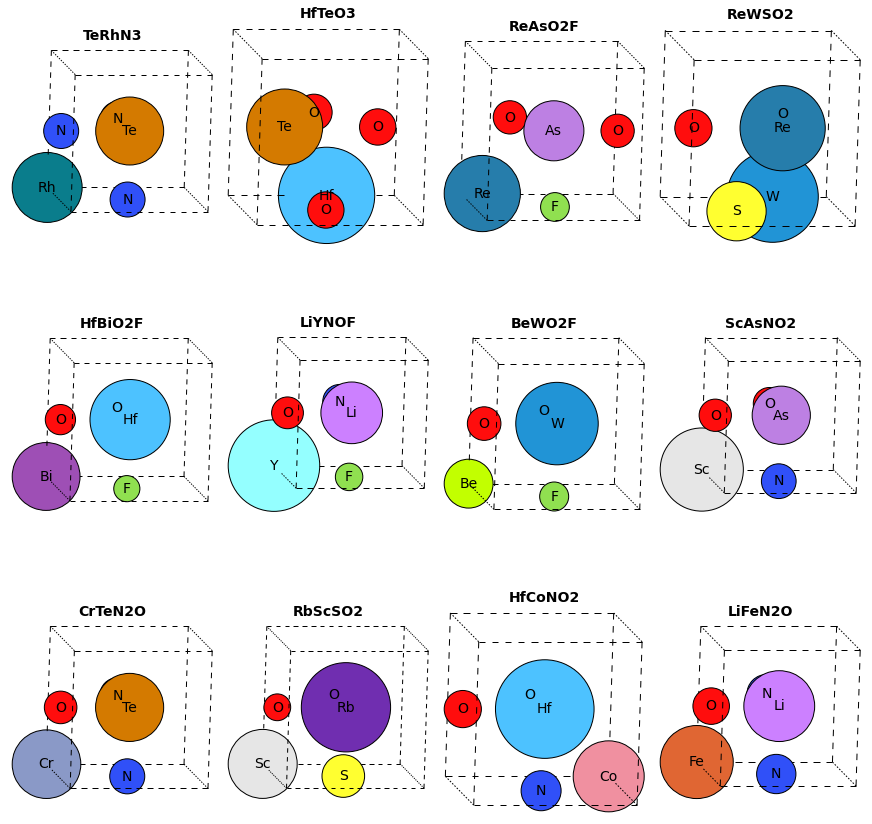

In [3]:
fig, axs = plt.subplots(3, 4, figsize=(12, 12))

for struct, ax in zip(df_perov.structure.head(12), axs.flat):
    ax = plot_structure_2d(struct, ax=ax)
    ax.set_title(struct.composition.reduced_formula, fontsize=14)


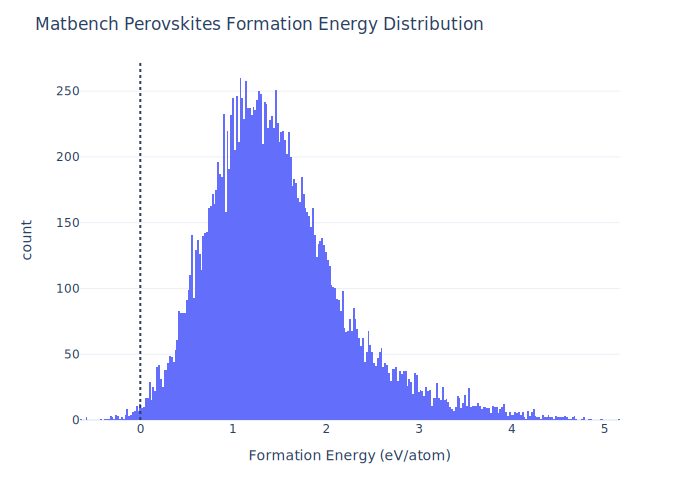

In [7]:
labels = {'e_form': 'Formation Energy (eV/atom)'}

fig = px.histogram(df_perov, x="e_form", nbins=300, labels=labels)

fig.update_layout(title="Matbench Perovskites Formation Energy Distribution")

fig.add_vline(x=0, fillcolor="black", line_width=2, line_dash="dot")


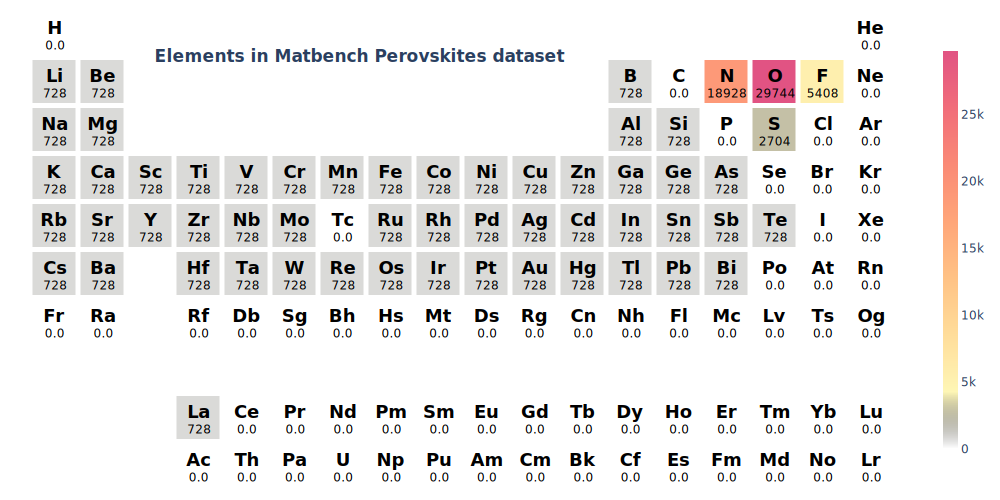

In [11]:
fig = ptable_heatmap_plotly(df_perov.formula)
fig.update_layout(title=dict(text="<b>Elements in Matbench Perovskites dataset<b>", x=0.36, y=0.9))


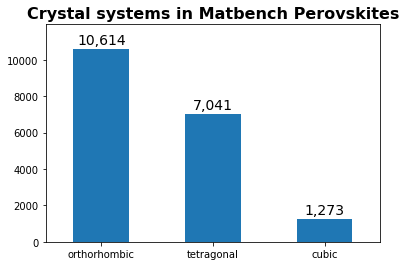

In [6]:
df_perov["crys_sys"].value_counts().plot.bar()

plt.title("Crystal systems in Matbench Perovskites")
plt.xticks(rotation="horizontal")

annotate_bars(v_offset=250)


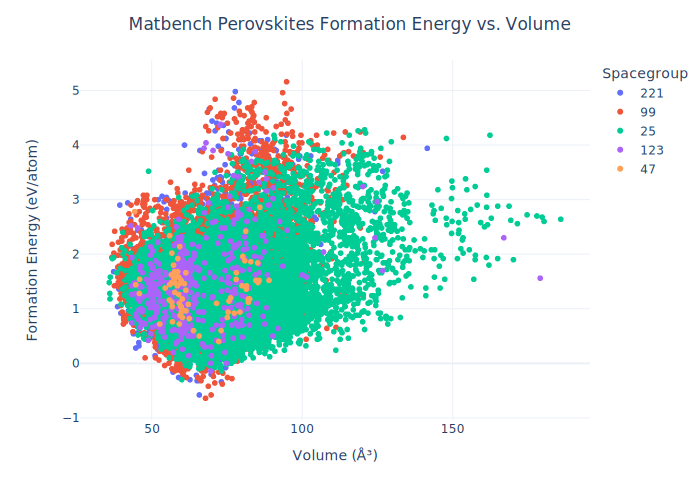

In [21]:
labels = {"spglib_spg_num": "Spacegroup", "e_form": "Formation Energy", "volume": "Volume"}

fig = px.scatter(
    df_perov, x="volume", y="e_form", color="spglib_spg_num", labels=labels
)
fig.update_layout(title="Matbench Perovskites Formation Energy vs. Volume", title_x=0.5)


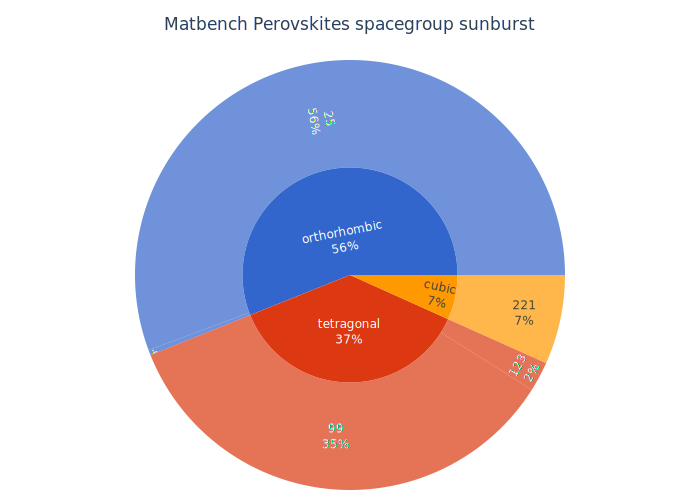

In [12]:
fig = spacegroup_sunburst(df_perov.spglib_spg_num, show_counts="percent")
fig.update_layout(title=dict(text="Matbench Perovskites spacegroup sunburst", x=0.5))


In [ ]:
# see https://github.com/CompRhys/aviary/blob/main/aviary/wren/utils.py
from aviary.wren.utils import get_aflow_label_aflow

# takes ~6h (when running uninterrupted)
for idx, struct in tqdm(df_perov.structure.items(), total=len(df_perov)):
    if pd.isna(df_perov.aflow_wyckoff[idx]):
        df_perov.at[idx, "aflow_wyckoff"] = get_aflow_label_aflow(
            struct, "/path/to/aflow"  # defaults to aflow
        )


In [6]:
df_perov['aflow_wyckoff'] = pd.read_csv('/Users/janosh/dev/aviary/datasets/matbench_perovskites_aflow_labels.csv').aflow_wyckoff

In [2]:
# uncomment line to cache expensive aflow results
# %store df_perov

# uncomment line to reload cached dataframe
%store -r df_perov

extract spacegroups and crystal systems from Aflow Wyckoff labels


In [14]:
df_perov["aflow_spg_num"] = df_perov.aflow_wyckoff.str.split("_").str[2].astype(int)
df_perov["aflow_crys_sys"] = df_perov.aflow_spg_num.map(get_crystal_sys)


Surprisingly large disparity between Spglib and Aflow spacegroups

Spglib is fast while Aflow uses a slower adaptive but presumably more correct algorithm.


sankey-spglib-vs-aflow-spacegroups.svg:
Done in 73 ms!
10.605 KiB - 37.6% = 6.617 KiB


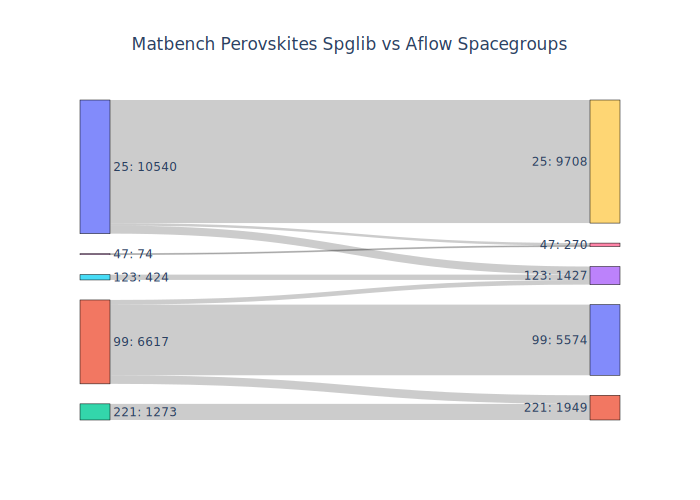

In [18]:
from pymatviz.sankey import sankey_from_2_df_cols
from pymatviz.utils import save_and_compress_svg

fig = sankey_from_2_df_cols(df_perov, ["spglib_spg_num", "aflow_spg_num"])

fig.update_layout(title="Matbench Perovskites Spglib vs Aflow Spacegroups", title_x=0.5)

save_and_compress_svg('sankey-spglib-vs-aflow-spacegroups', fig)

fig.show()

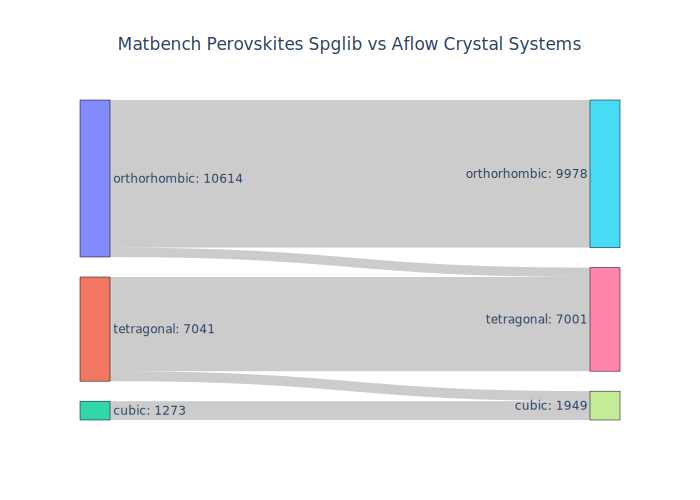

In [17]:
fig = sankey_from_2_df_cols(df_perov, ["spglib_crys_sys", "aflow_crys_sys"])

fig.update_layout(title="Matbench Perovskites Spglib vs Aflow Crystal Systems", title_x=0.5)
